In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.functions import *
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.types import IntegerType
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
%matplotlib inline

In [2]:
spark = SparkSession.builder.appName('YelpDatasetUser').getOrCreate()
#change configuration settings on Spark 
conf = spark.sparkContext._conf.setAll([('spark.executor.memory', '5g'), ('spark.app.name', 'Spark Updated Conf'), ('spark.executor.cores', '4'), ('spark.cores.max', '4'), ('spark.driver.memory','8g')])

#print spark configuration settings
spark.sparkContext.getConf().getAll()

[('spark.stage.maxConsecutiveAttempts', '10'),
 ('spark.dynamicAllocation.minExecutors', '1'),
 ('spark.eventLog.enabled', 'true'),
 ('spark.submit.pyFiles',
  '/root/.ivy2/jars/com.johnsnowlabs.nlp_spark-nlp_2.12-4.4.0.jar,/root/.ivy2/jars/graphframes_graphframes-0.8.2-spark3.1-s_2.12.jar,/root/.ivy2/jars/com.typesafe_config-1.4.2.jar,/root/.ivy2/jars/org.rocksdb_rocksdbjni-6.29.5.jar,/root/.ivy2/jars/com.amazonaws_aws-java-sdk-bundle-1.11.828.jar,/root/.ivy2/jars/com.github.universal-automata_liblevenshtein-3.0.0.jar,/root/.ivy2/jars/com.google.cloud_google-cloud-storage-2.16.0.jar,/root/.ivy2/jars/com.navigamez_greex-1.0.jar,/root/.ivy2/jars/com.johnsnowlabs.nlp_tensorflow-cpu_2.12-0.4.4.jar,/root/.ivy2/jars/it.unimi.dsi_fastutil-7.0.12.jar,/root/.ivy2/jars/org.projectlombok_lombok-1.16.8.jar,/root/.ivy2/jars/com.google.guava_guava-31.1-jre.jar,/root/.ivy2/jars/com.google.guava_failureaccess-1.0.1.jar,/root/.ivy2/jars/com.google.guava_listenablefuture-9999.0-empty-to-avoid-conflict-

In [3]:
user_file='gs://msca-bdp-student-gcs/GroupProject_Gr7/yelp_dataset/yelp_academic_dataset_user.json'

In [4]:
df = spark.read.json(user_file)

In [60]:
df.show()

+-------------+---------------+---------------+----------------+--------------+---------------+---------------+---------------+-----------------+----------------+------------------+-----------------+-----+--------------------+----+--------------------+-----+---------+------------+------+--------------------+-------------------+
|average_stars|compliment_cool|compliment_cute|compliment_funny|compliment_hot|compliment_list|compliment_more|compliment_note|compliment_photos|compliment_plain|compliment_profile|compliment_writer| cool|               elite|fans|             friends|funny|     name|review_count|useful|             user_id|      yelping_since|
+-------------+---------------+---------------+----------------+--------------+---------------+---------------+---------------+-----------------+----------------+------------------+-----------------+-----+--------------------+----+--------------------+-----+---------+------------+------+--------------------+-------------------+
|         

In [6]:
df.summary().show()

+-------+------------------+------------------+-------------------+------------------+------------------+-------------------+-------------------+------------------+-----------------+------------------+-------------------+-----------------+------------------+-----------------+------------------+--------------------+------------------+------------+------------------+-----------------+--------------------+-------------------+
|summary|     average_stars|   compliment_cool|    compliment_cute|  compliment_funny|    compliment_hot|    compliment_list|    compliment_more|   compliment_note|compliment_photos|  compliment_plain| compliment_profile|compliment_writer|              cool|            elite|              fans|             friends|             funny|        name|      review_count|           useful|             user_id|      yelping_since|
+-------+------------------+------------------+-------------------+------------------+------------------+-------------------+-------------------+-

In [7]:
df.printSchema()

root
 |-- average_stars: double (nullable = true)
 |-- compliment_cool: long (nullable = true)
 |-- compliment_cute: long (nullable = true)
 |-- compliment_funny: long (nullable = true)
 |-- compliment_hot: long (nullable = true)
 |-- compliment_list: long (nullable = true)
 |-- compliment_more: long (nullable = true)
 |-- compliment_note: long (nullable = true)
 |-- compliment_photos: long (nullable = true)
 |-- compliment_plain: long (nullable = true)
 |-- compliment_profile: long (nullable = true)
 |-- compliment_writer: long (nullable = true)
 |-- cool: long (nullable = true)
 |-- elite: string (nullable = true)
 |-- fans: long (nullable = true)
 |-- friends: string (nullable = true)
 |-- funny: long (nullable = true)
 |-- name: string (nullable = true)
 |-- review_count: long (nullable = true)
 |-- useful: long (nullable = true)
 |-- user_id: string (nullable = true)
 |-- yelping_since: string (nullable = true)



In [8]:
df.select("average_stars", "cool", "funny", "useful").describe().show()


+-------+------------------+------------------+------------------+-----------------+
|summary|     average_stars|              cool|             funny|           useful|
+-------+------------------+------------------+------------------+-----------------+
|  count|           1987897|           1987897|           1987897|          1987897|
|   mean|3.6304941503508696|23.792913817969442|16.970536199813168|42.29633527290398|
| stddev|1.1833369995975145| 565.3512954713351|407.80343748410183|641.4805967755901|
|    min|               1.0|                 0|                 0|                0|
|    max|               5.0|            199878|            185823|           206296|
+-------+------------------+------------------+------------------+-----------------+



In [9]:
print("Number of distinct users:", df.select("user_id").distinct().count())


Number of distinct users: 1987897


In [10]:
# Calculate the average number of reviews per user
avg_reviews_per_user = df.groupBy("user_id").agg(count("user_id").alias("num_reviews")).agg(avg("num_reviews")).collect()[0][0]
print("Average number of reviews per user:", avg_reviews_per_user)

Average number of reviews per user: 1.0


In [35]:
# df.select(‘class’).distinct().rdd.map(lambda r: r[0]).collect()


In [34]:
# # Calculate the average number of compliments received by users
# compliments_cols = [col for col in df.columns if "compliment_" in col]
# df = df.withColumn("total_compliments_received", sum([df[col] for col in compliments_cols]))
# avg_compliments_received = df.agg(avg("total_compliments_received")).collect()[0][0]
# print("Average number of compliments received by users:", avg_compliments_received)


In [11]:
df.select("average_stars", "cool", "funny", "useful").toPandas().corr()


,average_stars,cool,funny,useful
average_stars,1.000000,0.010437,0.007060,0.010973
cool,0.010437,1.000000,0.964872,0.991841
funny,0.007060,0.964872,1.000000,0.954307
useful,0.010973,0.991841,0.954307,1.000000


In [12]:
# Select only the numeric columns
numeric_cols = [col for col in df.columns if col not in ['user_id', 'elite', 'friends', 'name', 'yelping_since']]
df_numeric = df.select([col(c).cast("double").alias(c) for c in numeric_cols])

# Vectorize the numeric columns
assembler = VectorAssembler(inputCols=numeric_cols, outputCol="features")
df_vectorized = assembler.transform(df_numeric).select("features")

# Calculate the correlation matrix
correlation_matrix = Correlation.corr(df_vectorized, "features", "pearson").head()
# print("Correlation matrix:\n", str(correlation_matrix[0]))
print(correlation_matrix)

Row(pearson(features)=DenseMatrix(17, 17, [1.0, 0.0073, 0.0026, 0.0073, 0.0059, 0.0014, 0.0045, 0.0049, ..., 0.6632, 0.3602, 0.7, 0.9918, 0.6432, 0.9543, 0.5734, 1.0], False))


In [40]:
print('Data frame describe (string and numeric columns only):')
df.describe().toPandas()

Data frame describe (string and numeric columns only):


,summary,average_stars,compliment_cool,compliment_cute,compliment_funny,compliment_hot,compliment_list,compliment_more,compliment_note,compliment_photos,...,cool,elite,fans,friends,funny,name,review_count,useful,user_id,yelping_since
0,count,1987897,1987897,1987897,1987897,1987897,1987897,1987897,1987897,1987897,...,1987897,1987897,1987897,1987897,1987897,1987897,1987897,1987897,1987897,1987897
1,mean,3.6304941503508696,2.8293080577112395,0.13364927860950543,2.8293080577112395,1.8070724992290847,0.06390723463036566,0.29226313033321144,1.4431346292086562,1.226859339291724,...,23.792913817969442,2017.220760233918,1.4657404282012598,None,16.970536199813168,NaN,23.394409267683386,42.29633527290398,None,None
2,stddev,1.1833369995975145,96.66385446471259,11.356823097797161,96.66385446471259,73.60184094967366,10.04362659411937,12.824667119930176,60.16790049259037,95.15751297164893,...,565.3512954713351,4.093635046480389,18.13075272385579,None,407.8034374841018,NaN,82.56699161797889,641.4805967755902,None,None
3,min,1.0,0,0,0,0,0,0,0,0,...,0,,0,"---2PmXbF47D870stH1jqA, AgkO3LoVmmW6NyMZdHQmSw...",0,Chris,0,0,---1lKK3aKOuomHnwAkAow,2004-10-12 08:46:11
4,max,5.0,49967,13654,49967,25784,12669,13501,59031,82630,...,199878,2021,12497,"zzzOOwSYzuTPvsafSCzDPw, djDWZw59RlGHuXKw20kyzQ...",185823,Ｊｏａｎｎｅ,17473,206296,zzzUFM4HFe0SFG0bPjntQA,2022-01-19 17:15:47


In [41]:
print('Columns overview')
pd.DataFrame(df.dtypes, columns = ['Column Name','Data type'])

Columns overview


,Column Name,Data type
0,average_stars,double
1,compliment_cool,bigint
2,compliment_cute,bigint
3,compliment_funny,bigint
4,compliment_hot,bigint
5,compliment_list,bigint
6,compliment_more,bigint
7,compliment_note,bigint
8,compliment_photos,bigint
9,compliment_plain,bigint


In [52]:
ranked_users_df = df.select(df.compliment_cool, df.average_stars) \
    .distinct() \
    .groupBy(df.compliment_cool) \
    .count() \
    .orderBy("count", ascending=False)

# Top 5 workout types
highest_users_df = ranked_users_df.limit(5).toPandas()
# Rename column name : 'count' --> Users count
highest_users_df.rename(columns = {'count':'Users count'}, inplace = True)
# Caculate the total users, we will this result to compute percentage later
total_users = ranked_users_df.groupBy().sum().collect()[0][0]

In [ ]:
ranked_users_df.collect()[:5]

In [87]:
# Compute the interquartile range
q1, q3 = df.approxQuantile("review_count", [0.25, 0.75], 0)
iqr = q3 - q1

# Compute the number of data points
n = df.count()

# Compute the bin width using the Freedman-Diaconis rule
bin_width = 2 * iqr / (n ** (1/3))
print(bin_width)
# # Compute the number of bins
# num_bins = int((df.select(F.max("review_count")).collect()[0][0] - df.select(F.min("review_count")).collect()[0][0]) / bin_width)

# # Create a histogram chart
# df.select("review_count").rdd.flatMap(lambda x: x).histogram(num_bins)

0.2385924125571478


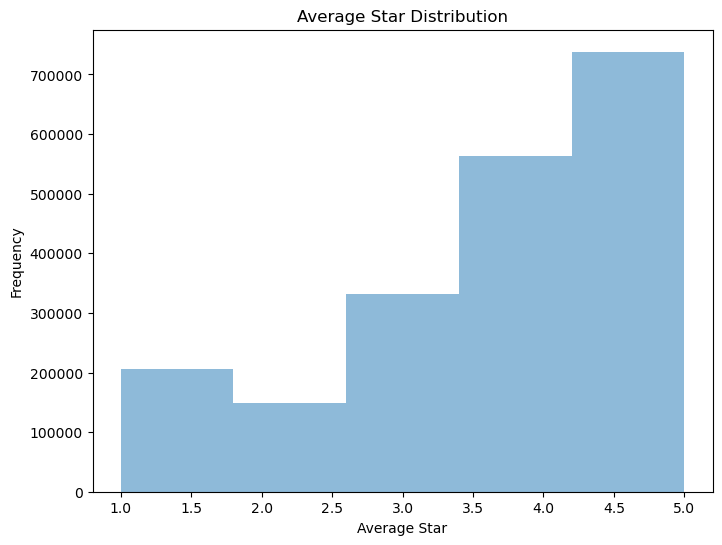

In [89]:
plt.figure(figsize=(8, 6))
data = df.select('average_stars').toPandas()
plt.hist(data['average_stars'], bins=5, alpha=0.5)
plt.title('Average Star Distribution')
plt.xlabel('Average Star')
plt.ylabel('Frequency')
plt.show()

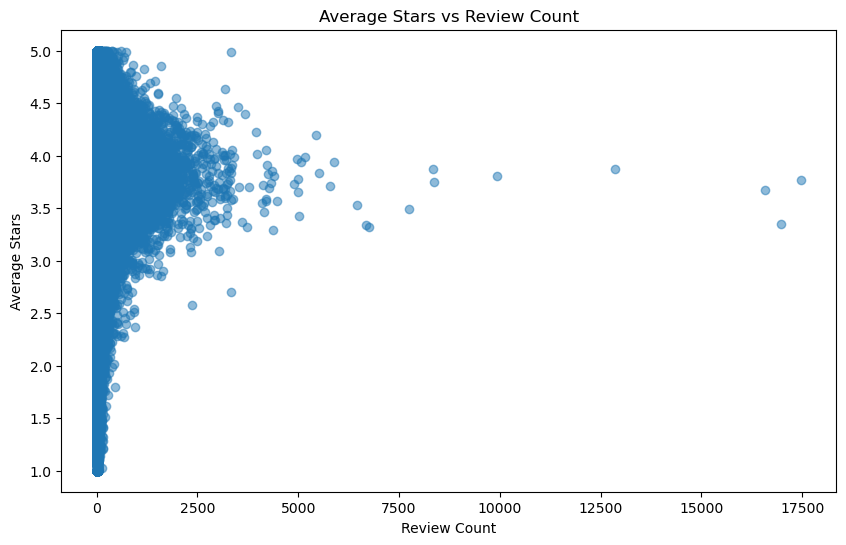

In [66]:
df_pd = df.select('average_stars', 'review_count').toPandas()

plt.figure(figsize=(10, 6))
plt.scatter(df_pd['review_count'], df_pd['average_stars'], alpha=0.5)
plt.xlabel('Review Count')
plt.ylabel('Average Stars')
plt.title('Average Stars vs Review Count')
plt.show()

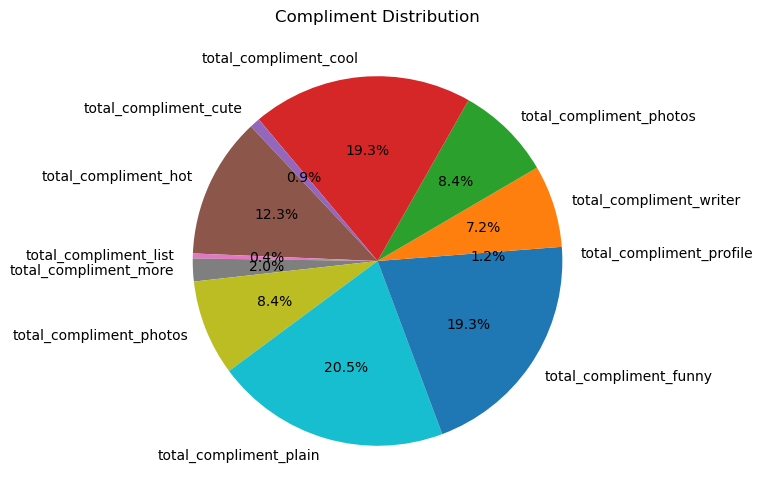

In [67]:
df_agg = df.agg(
    F.sum('compliment_profile').alias('total_compliment_profile'),
    F.sum('compliment_writer').alias('total_compliment_writer'),
    F.sum('compliment_photos').alias('total_compliment_photos'),
    F.sum('compliment_cool').alias('total_compliment_cool'),
    F.sum('compliment_cute').alias('total_compliment_cute'),
    F.sum('compliment_hot').alias('total_compliment_hot'),
    F.sum('compliment_list').alias('total_compliment_list'),
    F.sum('compliment_more').alias('total_compliment_more'),
    F.sum('compliment_photos').alias('total_compliment_photos'),
    F.sum('compliment_plain').alias('total_compliment_plain'),
    F.sum('compliment_funny').alias('total_compliment_funny')

)
df_agg_pd = df_agg.toPandas().T.reset_index()
df_agg_pd.columns = ['compliment', 'total_count']

plt.figure(figsize=(10, 6))
plt.pie(df_agg_pd['total_count'], labels=df_agg_pd['compliment'], autopct='%1.1f%%')
plt.title('Compliment Distribution')
plt.show()

In [ ]:
# compliment_columns=['compliment_profile','compliment_writer','compliment_photos','compliment_cute','compliment_hot','compliment_list','compliment_more','compliment_photos','compliment_plain','compliment_funny','cool','useful']
# for x in compliment_columns: 
#     plt.figure(figsize=(8, 6))
#     data = df.select(x).toPandas()
#     plt.hist(data[x], bins=5, alpha=0.5)
#     plt.title(f'{x} Distribution')
#     plt.xlabel(f'{x}')
#     plt.ylabel('Frequency')
#     plt.show()

compliment_profile


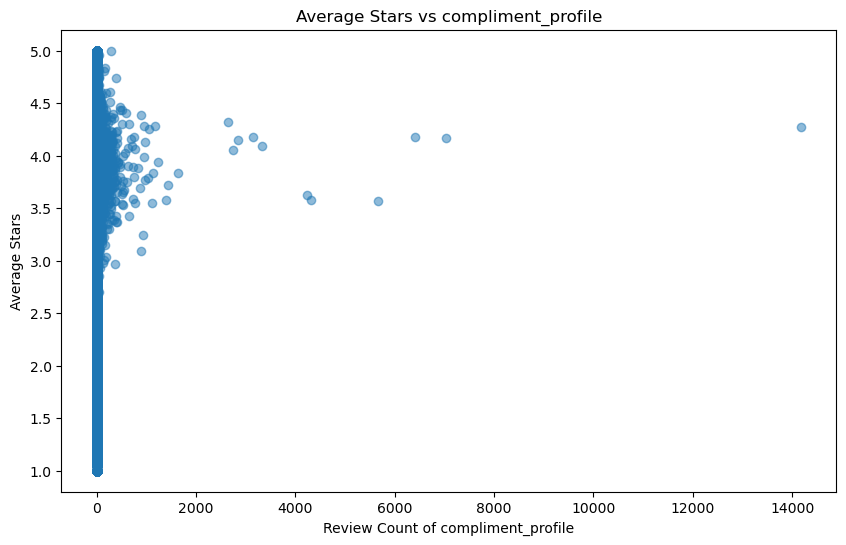

compliment_writer


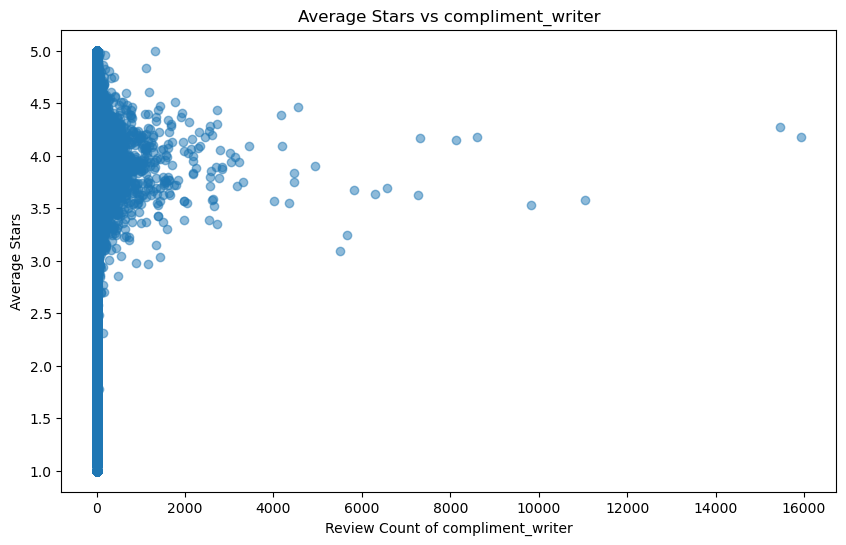

compliment_photos


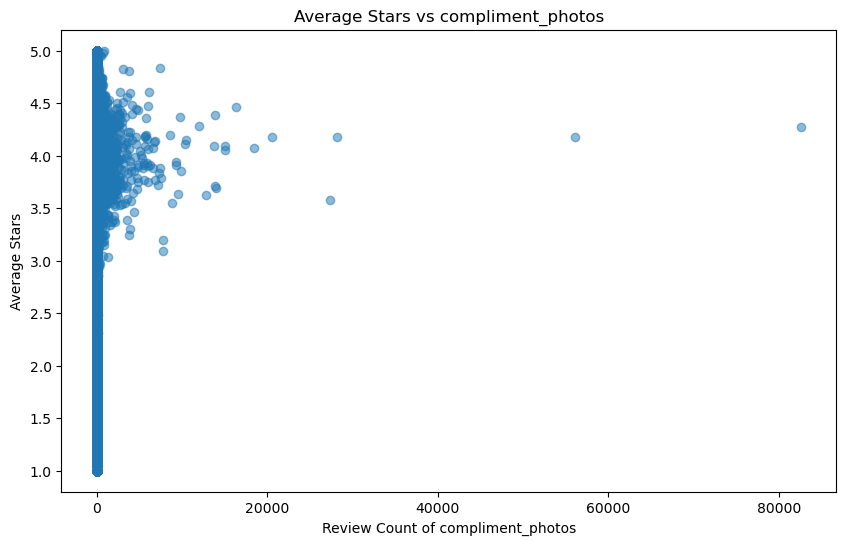

compliment_cute


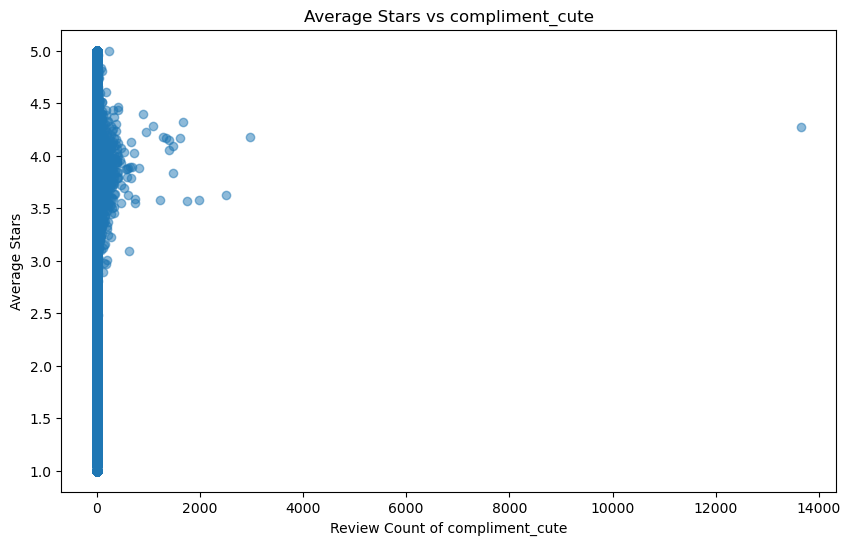

compliment_hot


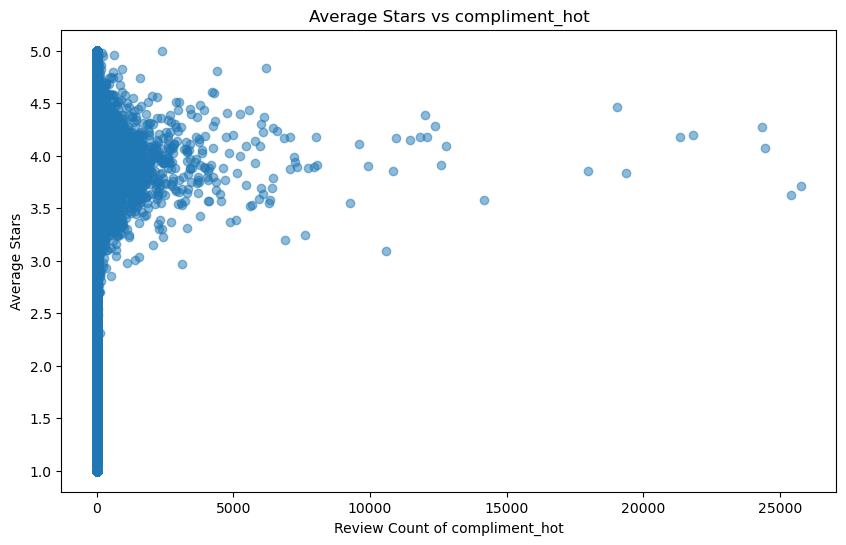

compliment_list


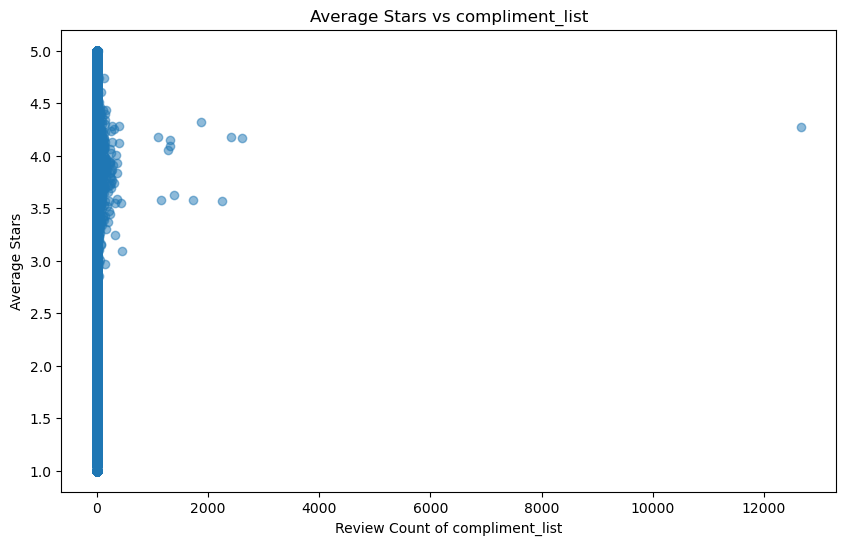

compliment_more


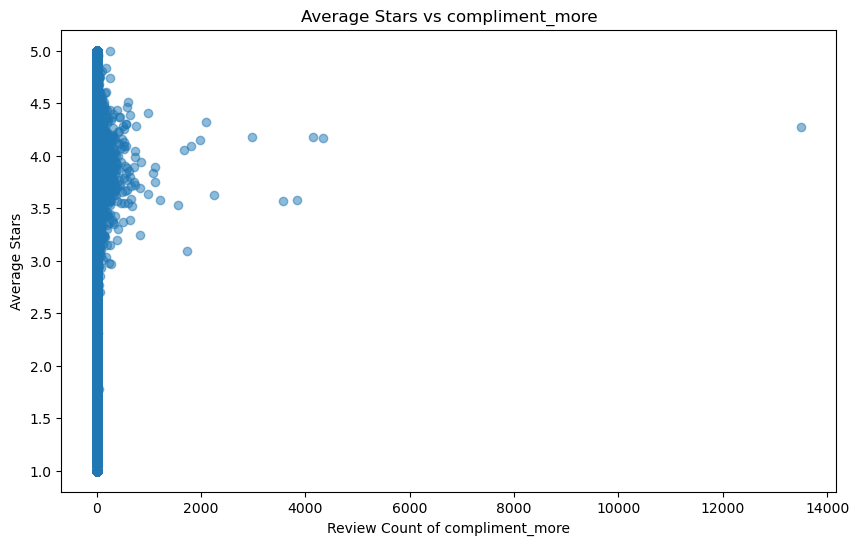

compliment_photos


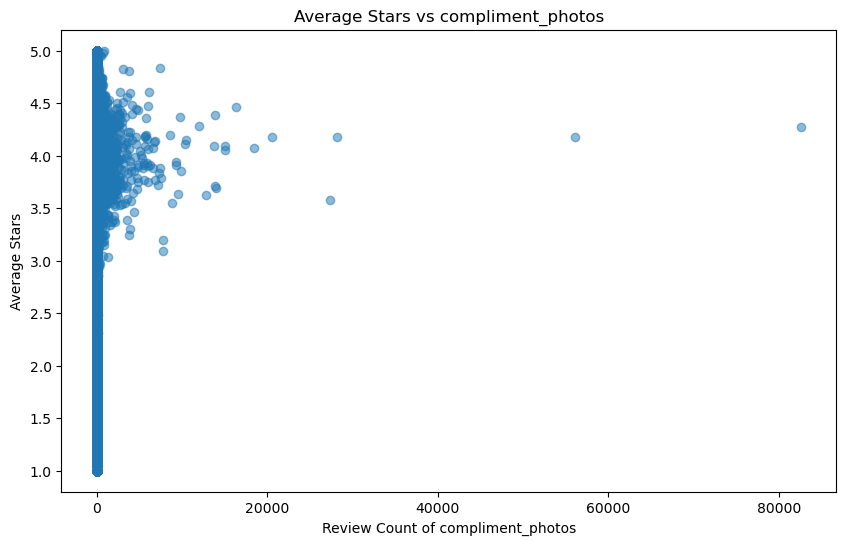

compliment_plain


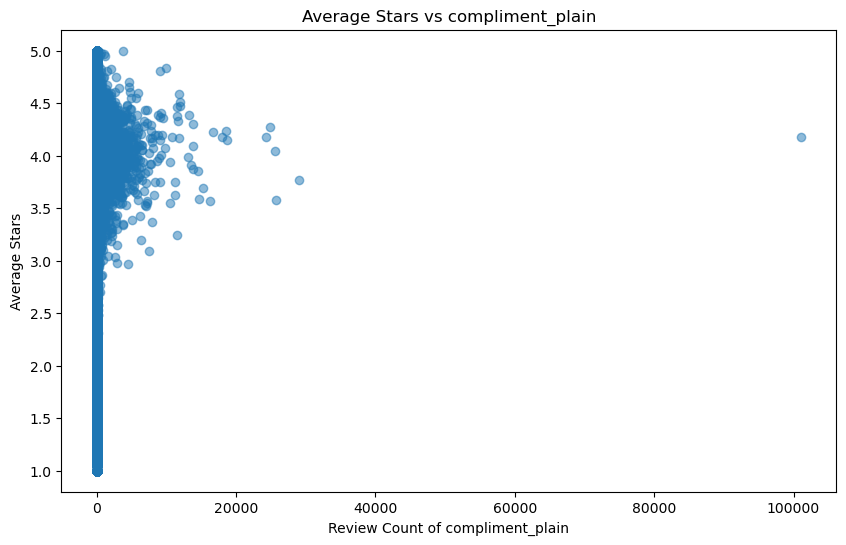

compliment_funny


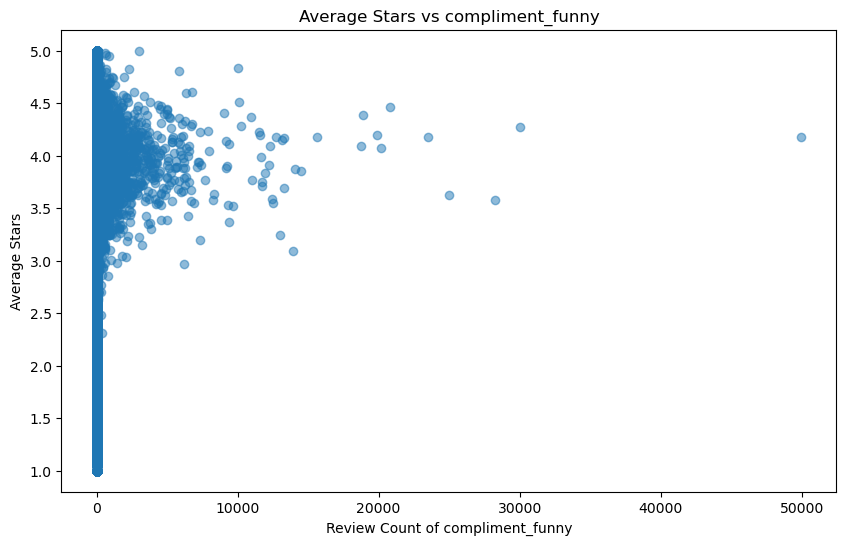

cool


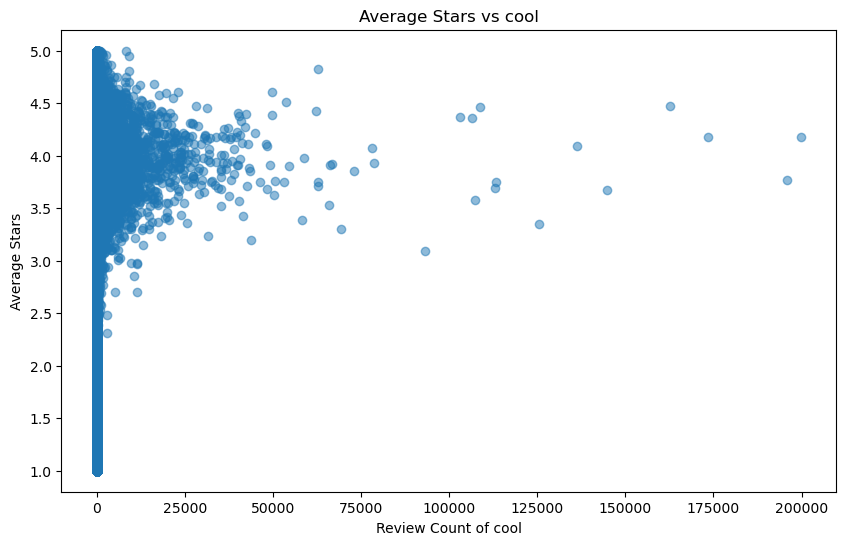

useful


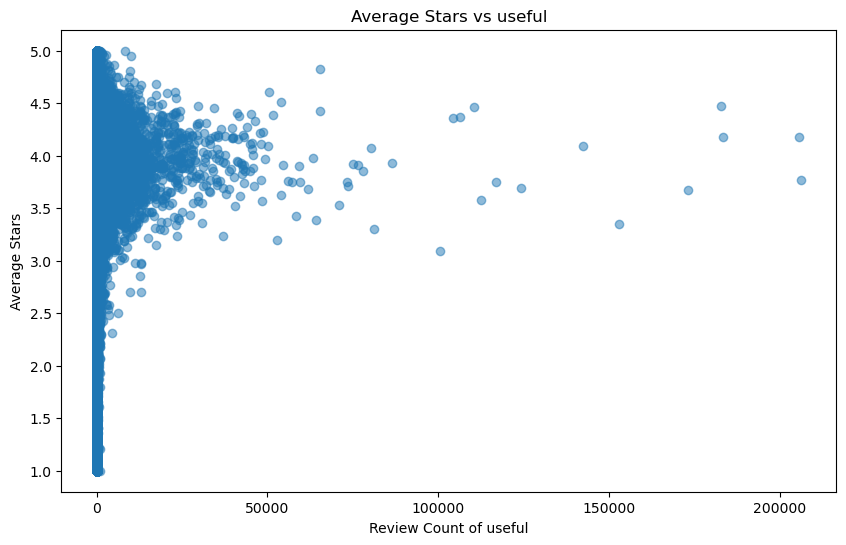

fans


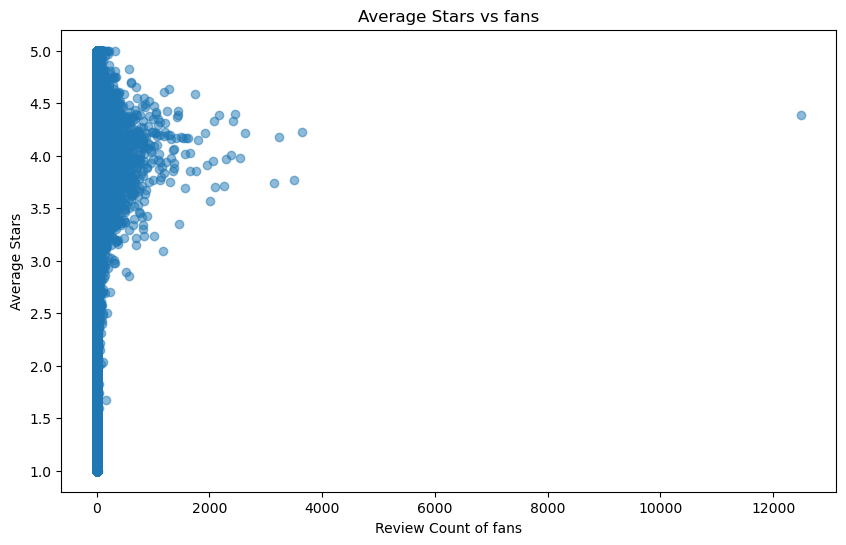

funny


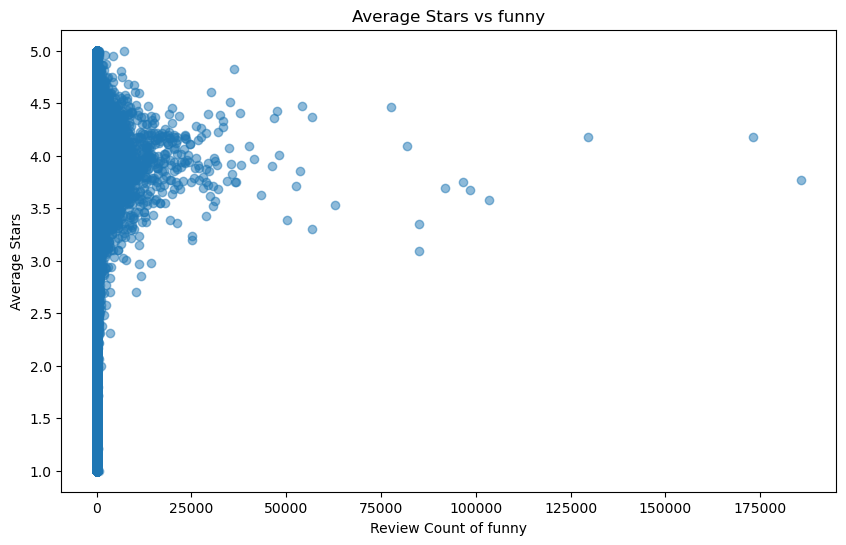

In [94]:
compliment_columns=['compliment_profile','compliment_writer','compliment_photos','compliment_cute','compliment_hot','compliment_list','compliment_more','compliment_photos','compliment_plain','compliment_funny','cool','useful','fans','funny']

for x in compliment_columns:
    df_pd_col = df.select('average_stars', x).toPandas()
    print(x)
    plt.figure(figsize=(10, 6))
    plt.scatter(df_pd_col[x], df_pd_col['average_stars'], alpha=0.5)
    plt.xlabel(f'Review Count of {x}')
    plt.ylabel('Average Stars')
    plt.title(f'Average Stars vs {x}')
    plt.show()

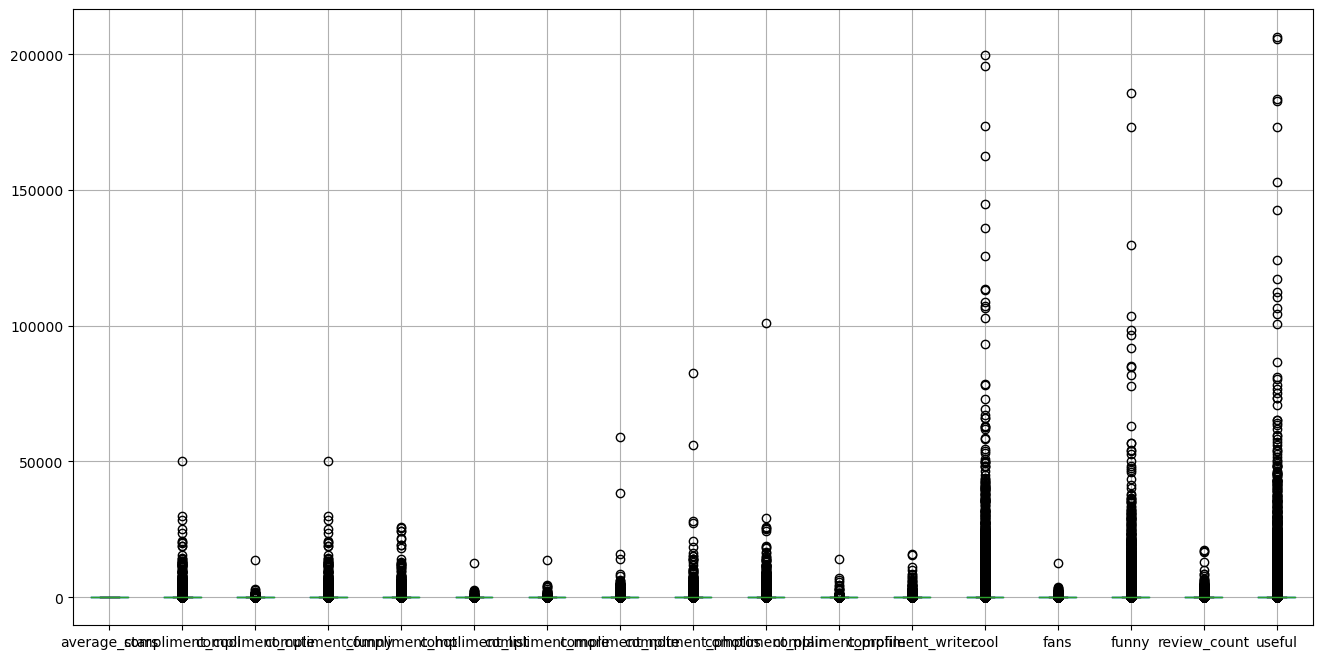

In [5]:
# compliment_columns=['compliment_profile','compliment_writer','compliment_photos','compliment_cute','compliment_hot','compliment_list','compliment_more','compliment_photos','compliment_plain','compliment_funny','cool','useful','fans','funny']

# for x in compliment_columns:
#     df_pd_col = df.select('average_stars', x).toPandas()
#     print(x)
#     plt.figure(figsize=(10, 6))
#     plt.scatter(df_pd_col[x], df_pd_col['average_stars'], alpha=0.5)
#     plt.xlabel(f'Review Count of {x}')
#     plt.ylabel('Average Stars')
#     plt.title(f'Average Stars vs {x}')
#     plt.show()
numeric_cols = [col(column) for column, dtype in df.dtypes if dtype != 'string']
df.select(numeric_cols).toPandas().boxplot(figsize=(16,8))

#df.select("compliment_profile").toPandas().boxplot(figsize=(16,8))
# df_box= df.select('compliment_profile').toPandas()
# df_box.boxplot(figsize=(16,8))
plt.show()
    
    

In [ ]:
# Compute correlation matrix
df_corr=df.toPandas()
corr = df_corr.corr()

# Plot heatmap
sns.heatmap(corr, cmap='coolwarm', annot=True)
plt.title('Correlation Matrix Heatmap')
plt.show()